In [ ]:
#!git clone https://github.com/rwightman/efficientdet-pytorch.git
#!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d1-4c7ebaf2.pth
#!mv tf_efficientdet_d1-4c7ebaf2.pth tf_efficientdet_d1.pth

In [ ]:
#!pip install timm
#!pip install omegaconf
#!pip install tensorboard

### [apex](https://github.com/NVIDIA/apex)


In [ ]:
#!git clone https://github.com/NVIDIA/apex
#!cd apex
#!pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./

### config

In [1]:
import os
import sys
import time
from datetime import datetime
import argparse
import torch
import torchvision.utils
from pycocotools.coco import COCO

sys.path.append(os.path.join('./efficientdet-pytorch'))
sys.path.append(os.path.join('./apex'))


try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as DDP
    from apex.parallel import convert_syncbn_model
    from apex.optimizers import FusedSGD #,FusedNovoGrad, FusedAdam, FusedLAMB
    has_apex = True
except ImportError:
    from torch.nn.parallel import DistributedDataParallel as DDP
    has_apex = False


#has_apex = False
print("Using apex:", has_apex)

from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, COCOEvaluator, unwrap_bench
from effdet.efficientdet import HeadNet
from data import transforms as efdetTF
from data import create_loader, CocoDetection

from timm.models import resume_checkpoint, load_checkpoint
from timm.utils import *
from timm.optim import create_optimizer
from timm.scheduler import create_scheduler, CosineLRScheduler

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./output/t1/logs")

torch.backends.cudnn.benchmark = True

Using apex: False


ModuleNotFoundError: No module named 'effdet'

In [4]:
# 設定
img_size = 640
BatchSize = 20
setup_default_logging()

## ローダーの設定

In [5]:
#dataset_train = CocoDetection('../../ballod_dataset/', "./annotations/train_ball_coco.json")
dataset_train = CocoDetection("./", "./train_cocoAno.json")

loading annotations into memory...
Done (t=1.52s)
creating index...
index created!


In [6]:
loader_train = create_loader(dataset_train, batch_size=BatchSize, input_size=img_size, is_training=True, use_prefetcher=True,
                            interpolation="random", num_workers=1, distributed=False, pin_mem=False)

(640, 640, 3)
{'img_id': 999, 'bbox': array([[  0.      ,   0.      , 142.68845 ,  93.64639 ],
       [ 47.564392, 120.665695, 141.20605 , 292.77936 ]], dtype=float32), 'cls': array([1, 1]), 'img_size': (640, 347), 'img_scale': 2.111453458856479}


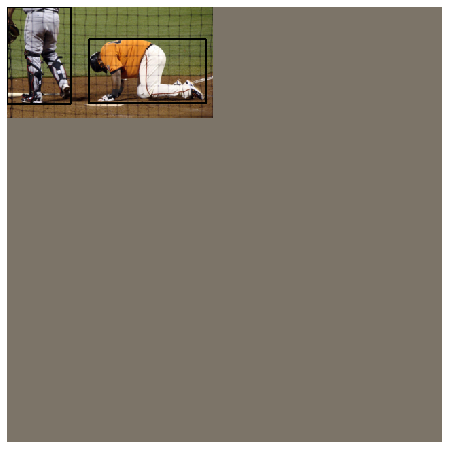

In [60]:
import matplotlib.pyplot as plt
import cv2
img, target = dataset_train[100]
img = img.transpose(1,2,0)
print(img.shape)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
print(target)
boxes = target['bbox']
for box in boxes:
    cv2.rectangle(img, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)
    
ax.set_axis_off()
ax.imshow(img);

In [57]:
dataset_eval = CocoDetection("./", "./eval_cocoAno.json")

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [7]:
loader_eval = create_loader(dataset_eval, batch_size=BatchSize, input_size=img_size, is_training=False, use_prefetcher=True,
                            interpolation="", num_workers=1, distributed=False, pin_mem=False)

In [8]:
evaluator = COCOEvaluator(dataset_eval.coco, distributed=False)

## モデルの設定

In [9]:
model_name = "tf_efficientdet_d1"
pretrained = True
prefetcher = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [10]:
!ls

annotations		      eval_cocoAno.json     tf_efficientdet_d1.pth
annotations_trainval2017.zip  eval_create.ipynb     train2017
apex			      eval_issia	    train_cocoAno.json
cocoAno.json		      issia		    train_issia
dataset_create.ipynb	      learning_efdet.ipynb  val2017
ed_pytorch.ipynb	      output
efficientdet-pytorch	      temp.json


In [11]:
# model load
def get_net():
    config = get_efficientdet_config('tf_efficientdet_d1')
    net = EfficientDet(config, pretrained_backbone=False)
    checkpoint = torch.load('./tf_efficientdet_d1.pth')
    net.load_state_dict(checkpoint)
    config.num_classes = 2
    config.image_size = img_size
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)
model = get_net()

In [12]:
model.to(device)
print("Cuda use")

Cuda use


In [ ]:
warmup_learning_rate = 1e-5
learning_rate = 1e-5 * 4
learning_rate_min = 1e-9

In [13]:
parameters = model.parameters()
use_amp = False
if has_apex:
    optimizer = FusedSGD(parameters, lr=learning_rate, momentum=0.9, weight_decay=4e-5, nesterov=True)
    model, optimizer = amp.initialize(model, optimizer, opt_level='O1')
    use_amp = True
else:
    optimizer = torch.optim.AdamW(parameters, lr=0.04)

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [14]:
#model_ema = ModelEma(model, decay=0.9998)


In [15]:
eval_metric = "loss"

exp_name = '-'.join([datetime.now().strftime("%Y%m%d-%H%M%S"), model_name])
output_dir = get_outdir("./output/t1", 'train', exp_name)
decreasing = True if eval_metric == 'loss' else False
saver = CheckpointSaver(checkpoint_dir=output_dir, decreasing=decreasing)

## スケジューラ

In [16]:
epochs = 50
warmup_epochs = 5
cooldown_epochs = 10
num_epochs = epochs
noise_range = None
lr_scheduler = CosineLRScheduler(
            optimizer,
            t_initial=num_epochs,
            t_mul=1.0,
            lr_min=learning_rate_min,
            decay_rate=0.1,
            warmup_lr_init=warmup_learning_rate,
            warmup_t=warmup_epochs,
            cycle_limit=1,
            t_in_epochs=True,
            noise_range_t=noise_range,
            noise_pct=0.67,
            noise_std=1.0,
            noise_seed=42,
        )
num_epochs = lr_scheduler.get_cycle_length() + cooldown_epochs
start_epoch = 0

# train

In [17]:
def train_epoch(epoch, model, loader, optimizer,  lr_scheduler=None, saver=None, output_dir='', use_amp=False, model_ema=None):
    """
    if args.prefetcher and args.mixup > 0 and loader.mixup_enabled:
        if args.mixup_off_epoch and epoch >= args.mixup_off_epoch:
            loader.mixup_enabled = False
    """
    
    batch_time_m = AverageMeter()
    data_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.train()

    end = time.time()
    last_idx = len(loader) - 1
    num_updates = epoch * len(loader)
    for batch_idx, (input, target) in enumerate(loader):
        #print(input, target)
        last_batch = batch_idx == last_idx
        data_time_m.update(time.time() - end)

        output = model(input, target)
        loss = output['loss']
        
        losses_m.update(loss.item(), input.size(0))
        #print(loss)
        #print(target)
        
        optimizer.zero_grad()
        clip_grad = 10
        if use_amp:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            torch.nn.utils.clip_grad_norm_(amp.master_params(optimizer), clip_grad)
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
        optimizer.step()

        torch.cuda.synchronize()
        if model_ema is not None:
            model_ema.update(model)
        num_updates += 1

        batch_time_m.update(time.time() - end)
        if last_batch or batch_idx % 50 == 0:
            lrl = [param_group['lr'] for param_group in optimizer.param_groups]
            lr = sum(lrl) / len(lrl)


            if True:
                logging.info(
                    'Train: {} [{:>4d}/{} ({:>3.0f}%)]  '
                    'Loss: {loss.val:>9.6f} ({loss.avg:>6.4f})  '
                    'Time: {batch_time.val:.3f}s, {rate:>7.2f}/s  '
                    '({batch_time.avg:.3f}s, {rate_avg:>7.2f}/s)  '
                    'LR: {lr:.3e}  '
                    'Data: {data_time.val:.3f} ({data_time.avg:.3f})'.format(
                        epoch,
                        batch_idx, len(loader),
                        100. * batch_idx / last_idx,
                        loss=losses_m,
                        batch_time=batch_time_m,
                        rate=input.size(0) * 1 / batch_time_m.val,
                        rate_avg=input.size(0) * 1 / batch_time_m.avg,
                        lr=lr,
                        data_time=data_time_m))

        if lr_scheduler is not None:
            lr_scheduler.step_update(num_updates=num_updates, metric=losses_m.avg)

        end = time.time()
        # end for

    if hasattr(optimizer, 'sync_lookahead'):
        optimizer.sync_lookahead()

    return OrderedDict([('loss', losses_m.avg)])

In [18]:
a = OrderedDict([('loss', 1)])
print(a)
print(a['loss'])

OrderedDict([('loss', 1)])
1


In [19]:
def validate(model, loader, evaluator=None, log_suffix=''):
    batch_time_m = AverageMeter()
    losses_m = AverageMeter()

    model.eval()

    end = time.time()
    last_idx = len(loader) - 1
    with torch.no_grad():
        for batch_idx, (input, target) in enumerate(loader):
            last_batch = batch_idx == last_idx

            output = model(input, target)
            loss = output['loss']
          

            if evaluator is not None:
                #detect = output['detections'].to('cpu').type(torch.int32)
                #target['bbox'].to('cpu').type(torch.int32)
                evaluator.add_predictions(output['detections'], target)
                
      
            reduced_loss = loss.data

            torch.cuda.synchronize()

            losses_m.update(reduced_loss.item(), input.size(0))

            batch_time_m.update(time.time() - end)
            end = time.time()
            if True and (last_batch or batch_idx % 50 == 0):
                log_name = 'Test' + log_suffix
                logging.info(
                    '{0}: [{1:>4d}/{2}]  '
                    'Time: {batch_time.val:.3f} ({batch_time.avg:.3f})  '
                    'Loss: {loss.val:>7.4f} ({loss.avg:>6.4f})  '.format(
                        log_name, batch_idx, last_idx, batch_time=batch_time_m, loss=losses_m))
            
    metrics = OrderedDict([('loss', losses_m.avg)])
    if evaluator is not None:
        metrics['map'] = evaluator.evaluate()

    return metrics

In [ ]:
best_metric = None
best_epoch = None
save_metric = None
try:
    for epoch in range(start_epoch, num_epochs):
        train_metrics = train_epoch(epoch, model, loader_train, optimizer,  lr_scheduler=lr_scheduler, saver=saver, output_dir=output_dir, use_amp=use_amp)
        
        writer.add_scalar("train_loss", train_metrics["loss"], epoch)
        
        eval_metrics = validate(model, loader_eval) # evaluator)
        
        writer.add_scalar("eval_loss", eval_metrics["loss"], epoch)
        #writer.add_scalar("eval", eval_metrics["map"], epoch)
        
        if lr_scheduler is not None:
            # step LR for next epoch
            lr_scheduler.step(epoch + 1, eval_metrics[eval_metric])

        if saver is not None:
            update_summary(
                epoch, train_metrics, eval_metrics, os.path.join(output_dir, 'summary.csv'),
                write_header=best_metric is None
            )

            # save proper checkpoint with eval metric
            class ArgPars():
                def __init__(self):
                    self.model = model_name
            args = ArgPars()
            save_metric = eval_metrics[eval_metric]
            best_metric, best_epoch = saver.save_checkpoint(unwrap_bench(model), optimizer, args, epoch=epoch, metric=save_metric, use_amp=use_amp)
except KeyboardInterrupt:
    pass
if best_metric is not None:
    logging.info('*** Best metric: {0} (epoch {1})'.format(best_metric, best_epoch))

writer.close()


Train: 0 [   0/3456 (  0%)]  Loss: 537.004883 (537.0049)  Time: 8.715s,    2.29/s  (8.715s,    2.29/s)  LR: 1.000e-04  Data: 0.798 (0.798)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0


Train: 0 [  50/3456 (  1%)]  Loss: 373.103271 (468.3328)  Time: 0.545s,   36.67/s  (0.705s,   28.36/s)  LR: 1.000e-04  Data: 0.011 (0.026)
Train: 0 [ 100/3456 (  3%)]  Loss: 303.381226 (424.4337)  Time: 0.547s,   36.55/s  (0.626s,   31.93/s)  LR: 1.000e-04  Data: 0.011 (0.018)
Train: 0 [ 150/3456 (  4%)]  Loss: 179.209183 (376.1252)  Time: 0.548s,   36.50/s  (0.600s,   33.36/s)  LR: 1.000e-04  Data: 0.011 (0.016)
Train: 0 [ 200/3456 (  6%)]  Loss: 143.946930 (335.0638)  Time: 0.545s,   36.68/s  (0.587s,   34.07/s)  LR: 1.000e-04  Data: 0.010 (0.014)
Train: 0 [ 250/3456 (  7%)]  Loss: 82.591270 (295.6014)  Time: 0.545s,   36.73/s  (0.579s,   34.57/s)  LR: 1.000e-04  Data: 0.010 (0.014)
Train: 0 [ 300/3456 (  9%)]  Loss: 46.317493 (260.8847)  Time: 0.548s,   36.47/s  (0.573s,   34.90/s)  LR: 1.000e-04  Data: 0.011 (0.013)
Train: 0 [ 350/3456 ( 10%)]  Loss: 27.238207 (230.6961)  Time: 0.548s,   36.52/s  (0.569s,   35.15/s)  LR: 1.000e-04  Data: 0.011 (0.013)
Train: 0 [ 400/3456 ( 12%)]  L

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 2 [3250/3456 ( 94%)]  Loss:  2.499962 (0.5468)  Time: 0.969s,   20.64/s  (0.544s,   36.79/s)  LR: 1.606e-02  Data: 0.431 (0.015)
Train: 2 [3300/3456 ( 96%)]  Loss:  3.065710 (0.5924)  Time: 0.938s,   21.33/s  (0.549s,   36.42/s)  LR: 1.606e-02  Data: 0.405 (0.021)
Train: 2 [3350/3456 ( 97%)]  Loss:  6.289629 (0.6369)  Time: 0.902s,   22.17/s  (0.554s,   36.08/s)  LR: 1.606e-02  Data: 0.368 (0.026)
Train: 2 [3400/3456 ( 98%)]  Loss:  4.189095 (0.6788)  Time: 0.902s,   22.17/s  (0.559s,   35.76/s)  LR: 1.606e-02  Data: 0.367 (0.031)
Train: 2 [3450/3456 (100%)]  Loss:  0.757441 (0.7145)  Time: 0.849s,   23.55/s  (0.564s,   35.46/s)  LR: 1.606e-02  Data: 0.319 (0.035)
Train: 2 [3455/3456 (100%)]  Loss:  5.435573 (0.7191)  Time: 0.466s,   23.63/s  (0.564s,   19.50/s)  LR: 1.606e-02  Data: 0.038 (0.035)
Test: [   0/147]  Time: 0.862 (0.862)  Loss:  2.4070 (2.4070)  
Test: [  50/147]  Time: 0.262 (0.277)  Loss:  2.6684 (2.5473)  
Test: [ 100/147]  Time: 0.263 (0.271)  Loss:  2.5817 (2.

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 3 [3250/3456 ( 94%)]  Loss:  5.995880 (0.5770)  Time: 0.929s,   21.54/s  (0.538s,   37.15/s)  LR: 2.404e-02  Data: 0.395 (0.015)
Train: 3 [3300/3456 ( 96%)]  Loss:  5.503247 (0.6356)  Time: 0.900s,   22.21/s  (0.544s,   36.76/s)  LR: 2.404e-02  Data: 0.371 (0.021)
Train: 3 [3350/3456 ( 97%)]  Loss:  7.707211 (0.6909)  Time: 0.870s,   23.00/s  (0.549s,   36.41/s)  LR: 2.404e-02  Data: 0.316 (0.026)
Train: 3 [3400/3456 ( 98%)]  Loss:  4.499018 (0.7407)  Time: 0.878s,   22.79/s  (0.554s,   36.08/s)  LR: 2.404e-02  Data: 0.328 (0.030)
Train: 3 [3450/3456 (100%)]  Loss:  1.068467 (0.7786)  Time: 0.893s,   22.40/s  (0.559s,   35.77/s)  LR: 2.404e-02  Data: 0.356 (0.035)
Train: 3 [3455/3456 (100%)]  Loss:  7.320656 (0.7824)  Time: 0.484s,   22.72/s  (0.559s,   19.67/s)  LR: 2.404e-02  Data: 0.038 (0.035)
Test: [   0/147]  Time: 0.884 (0.884)  Loss:  2.9523 (2.9523)  
Test: [  50/147]  Time: 0.281 (0.293)  Loss:  3.4284 (3.1829)  
Test: [ 100/147]  Time: 0.278 (0.287)  Loss:  3.0430 (3.

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 5 [ 100/3456 (  3%)]  Loss:  0.615164 (0.9861)  Time: 0.523s,   38.21/s  (0.547s,   36.55/s)  LR: 3.997e-02  Data: 0.010 (0.019)
Train: 5 [ 150/3456 (  4%)]  Loss:  0.583408 (0.8614)  Time: 0.544s,   36.76/s  (0.542s,   36.90/s)  LR: 3.997e-02  Data: 0.011 (0.016)
Train: 5 [ 200/3456 (  6%)]  Loss:  0.672137 (0.7984)  Time: 0.545s,   36.71/s  (0.543s,   36.82/s)  LR: 3.997e-02  Data: 0.011 (0.015)
Train: 5 [ 250/3456 (  7%)]  Loss:  0.595863 (0.7611)  Time: 0.544s,   36.79/s  (0.544s,   36.80/s)  LR: 3.997e-02  Data: 0.011 (0.014)
Train: 5 [ 300/3456 (  9%)]  Loss:  0.640045 (0.7295)  Time: 0.545s,   36.71/s  (0.544s,   36.78/s)  LR: 3.997e-02  Data: 0.011 (0.013)
Train: 5 [ 350/3456 ( 10%)]  Loss:  0.578159 (0.7071)  Time: 0.540s,   37.05/s  (0.544s,   36.77/s)  LR: 3.997e-02  Data: 0.011 (0.013)
Train: 5 [ 400/3456 ( 12%)]  Loss:  0.520771 (0.6891)  Time: 0.548s,   36.50/s  (0.544s,   36.76/s)  LR: 3.997e-02  Data: 0.011 (0.013)
Train: 5 [ 450/3456 ( 13%)]  Loss:  0.522382 (0.

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 6 [3250/3456 ( 94%)]  Loss:  2.024201 (0.5707)  Time: 0.984s,   20.31/s  (0.545s,   36.69/s)  LR: 3.996e-02  Data: 0.447 (0.015)
Train: 6 [3300/3456 ( 96%)]  Loss:  1.588229 (0.5862)  Time: 0.900s,   22.23/s  (0.551s,   36.33/s)  LR: 3.996e-02  Data: 0.370 (0.021)
Train: 6 [3350/3456 ( 97%)]  Loss:  0.733339 (0.5978)  Time: 0.904s,   22.12/s  (0.556s,   35.98/s)  LR: 3.996e-02  Data: 0.390 (0.026)
Train: 6 [3400/3456 ( 98%)]  Loss:  2.399501 (0.6097)  Time: 0.878s,   22.79/s  (0.561s,   35.65/s)  LR: 3.996e-02  Data: 0.360 (0.031)
Train: 6 [3450/3456 (100%)]  Loss:  0.746257 (0.6187)  Time: 0.878s,   22.79/s  (0.566s,   35.34/s)  LR: 3.996e-02  Data: 0.345 (0.036)
Train: 6 [3455/3456 (100%)]  Loss:  1.508338 (0.6196)  Time: 0.470s,   23.43/s  (0.566s,   19.43/s)  LR: 3.996e-02  Data: 0.038 (0.036)
Test: [   0/147]  Time: 0.888 (0.888)  Loss:  2.6813 (2.6813)  
Test: [  50/147]  Time: 0.283 (0.297)  Loss:  3.1101 (2.9182)  
Test: [ 100/147]  Time: 0.283 (0.290)  Loss:  2.9387 (2.

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 7 [3250/3456 ( 94%)]  Loss:  1.481962 (0.5533)  Time: 0.965s,   20.73/s  (0.535s,   37.41/s)  LR: 3.995e-02  Data: 0.446 (0.015)
Train: 7 [3300/3456 ( 96%)]  Loss:  1.650387 (0.5667)  Time: 0.896s,   22.33/s  (0.540s,   37.01/s)  LR: 3.995e-02  Data: 0.377 (0.021)
Train: 7 [3350/3456 ( 97%)]  Loss:  2.177628 (0.5782)  Time: 0.950s,   21.06/s  (0.546s,   36.63/s)  LR: 3.995e-02  Data: 0.417 (0.027)
Train: 7 [3400/3456 ( 98%)]  Loss:  2.437256 (0.5899)  Time: 0.858s,   23.32/s  (0.551s,   36.28/s)  LR: 3.995e-02  Data: 0.326 (0.032)
Train: 7 [3450/3456 (100%)]  Loss:  0.787583 (0.5973)  Time: 0.921s,   21.71/s  (0.556s,   35.96/s)  LR: 3.995e-02  Data: 0.405 (0.037)
Train: 7 [3455/3456 (100%)]  Loss:  1.528546 (0.5982)  Time: 0.444s,   24.76/s  (0.556s,   19.77/s)  LR: 3.995e-02  Data: 0.037 (0.037)
Test: [   0/147]  Time: 0.888 (0.888)  Loss:  2.5150 (2.5150)  
Test: [  50/147]  Time: 0.282 (0.296)  Loss:  3.0708 (2.8456)  
Test: [ 100/147]  Time: 0.280 (0.291)  Loss:  2.7236 (2.

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 8 [3400/3456 ( 98%)]  Loss:  1.296025 (0.5586)  Time: 0.891s,   22.44/s  (0.557s,   35.91/s)  LR: 3.993e-02  Data: 0.361 (0.031)
Train: 8 [3450/3456 (100%)]  Loss:  1.207570 (0.5660)  Time: 0.873s,   22.92/s  (0.562s,   35.61/s)  LR: 3.993e-02  Data: 0.338 (0.035)
Train: 8 [3455/3456 (100%)]  Loss:  0.824537 (0.5667)  Time: 0.462s,   23.80/s  (0.562s,   19.57/s)  LR: 3.993e-02  Data: 0.039 (0.035)
Test: [   0/147]  Time: 0.872 (0.872)  Loss:  2.3136 (2.3136)  
Test: [  50/147]  Time: 0.278 (0.292)  Loss:  2.9714 (2.6742)  
Test: [ 100/147]  Time: 0.281 (0.288)  Loss:  2.7717 (2.6634)  
Test: [ 147/147]  Time: 0.300 (0.332)  Loss:  1.5685 (2.5601)  
Current checkpoints:
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-0.pth.tar', 1.3770374389919076)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-8.pth.tar', 2.560091979600288)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-1.pth.tar', 2.560471292283084)
 ('./output/t1/train

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 9 [3250/3456 ( 94%)]  Loss:  1.695723 (0.5246)  Time: 0.919s,   21.76/s  (0.541s,   36.97/s)  LR: 3.991e-02  Data: 0.407 (0.015)
Train: 9 [3300/3456 ( 96%)]  Loss:  1.300756 (0.5349)  Time: 0.897s,   22.29/s  (0.547s,   36.59/s)  LR: 3.991e-02  Data: 0.380 (0.021)
Train: 9 [3350/3456 ( 97%)]  Loss:  0.855039 (0.5424)  Time: 0.869s,   23.03/s  (0.552s,   36.24/s)  LR: 3.991e-02  Data: 0.337 (0.026)
Train: 9 [3400/3456 ( 98%)]  Loss:  1.571495 (0.5502)  Time: 0.890s,   22.48/s  (0.557s,   35.91/s)  LR: 3.991e-02  Data: 0.358 (0.031)
Train: 9 [3450/3456 (100%)]  Loss:  0.849137 (0.5558)  Time: 0.869s,   23.03/s  (0.562s,   35.60/s)  LR: 3.991e-02  Data: 0.338 (0.036)
Train: 9 [3455/3456 (100%)]  Loss:  1.151210 (0.5564)  Time: 0.461s,   23.85/s  (0.562s,   19.57/s)  LR: 3.991e-02  Data: 0.037 (0.036)
Test: [   0/147]  Time: 0.882 (0.882)  Loss:  2.3277 (2.3277)  
Test: [  50/147]  Time: 0.281 (0.294)  Loss:  3.0101 (2.6995)  
Test: [ 100/147]  Time: 0.284 (0.290)  Loss:  2.8549 (2.

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Train: 10 [3300/3456 ( 96%)]  Loss:  1.625292 (0.5348)  Time: 0.942s,   21.24/s  (0.543s,   36.82/s)  LR: 3.989e-02  Data: 0.425 (0.021)
Train: 10 [3350/3456 ( 97%)]  Loss:  1.054451 (0.5413)  Time: 0.877s,   22.80/s  (0.548s,   36.47/s)  LR: 3.989e-02  Data: 0.362 (0.026)
Train: 10 [3400/3456 ( 98%)]  Loss:  1.161199 (0.5500)  Time: 0.882s,   22.69/s  (0.553s,   36.14/s)  LR: 3.989e-02  Data: 0.364 (0.031)
Train: 10 [3450/3456 (100%)]  Loss:  1.208770 (0.5550)  Time: 0.903s,   22.14/s  (0.558s,   35.83/s)  LR: 3.989e-02  Data: 0.370 (0.036)
Train: 10 [3455/3456 (100%)]  Loss:  1.155355 (0.5557)  Time: 0.448s,   24.54/s  (0.558s,   19.70/s)  LR: 3.989e-02  Data: 0.038 (0.036)
Test: [   0/147]  Time: 0.869 (0.869)  Loss:  2.5243 (2.5243)  
Test: [  50/147]  Time: 0.268 (0.280)  Loss:  3.0184 (2.8477)  
Test: [ 100/147]  Time: 0.267 (0.276)  Loss:  2.9117 (2.8449)  
Test: [ 147/147]  Time: 0.284 (0.322)  Loss:  1.6646 (2.7430)  
Current checkpoints:
 ('./output/t1/train/20200610-110221-t

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 12 [3250/3456 ( 94%)]  Loss:  1.149247 (0.5116)  Time: 0.946s,   21.15/s  (0.539s,   37.09/s)  LR: 3.984e-02  Data: 0.413 (0.015)
Train: 12 [3300/3456 ( 96%)]  Loss:  0.873721 (0.5196)  Time: 0.881s,   22.71/s  (0.545s,   36.70/s)  LR: 3.984e-02  Data: 0.348 (0.021)
Train: 12 [3350/3456 ( 97%)]  Loss:  0.960530 (0.5252)  Time: 0.916s,   21.82/s  (0.550s,   36.35/s)  LR: 3.984e-02  Data: 0.382 (0.026)
Train: 12 [3400/3456 ( 98%)]  Loss:  1.126794 (0.5310)  Time: 0.919s,   21.77/s  (0.555s,   36.03/s)  LR: 3.984e-02  Data: 0.385 (0.031)
Train: 12 [3450/3456 (100%)]  Loss:  0.838117 (0.5345)  Time: 0.880s,   22.73/s  (0.560s,   35.72/s)  LR: 3.984e-02  Data: 0.351 (0.035)
Train: 12 [3455/3456 (100%)]  Loss:  0.630152 (0.5350)  Time: 0.465s,   23.63/s  (0.560s,   19.63/s)  LR: 3.984e-02  Data: 0.039 (0.036)
Test: [   0/147]  Time: 0.880 (0.880)  Loss:  2.2905 (2.2905)  
Test: [  50/147]  Time: 0.285 (0.294)  Loss:  2.8333 (2.5667)  
Test: [ 100/147]  Time: 0.285 (0.289)  Loss:  2.63

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 13 [3250/3456 ( 94%)]  Loss:  2.165872 (0.5100)  Time: 0.963s,   20.77/s  (0.542s,   36.92/s)  LR: 3.982e-02  Data: 0.428 (0.015)
Train: 13 [3300/3456 ( 96%)]  Loss:  0.659838 (0.5170)  Time: 0.901s,   22.19/s  (0.547s,   36.54/s)  LR: 3.982e-02  Data: 0.368 (0.021)
Train: 13 [3350/3456 ( 97%)]  Loss:  0.814681 (0.5225)  Time: 0.899s,   22.25/s  (0.553s,   36.20/s)  LR: 3.982e-02  Data: 0.384 (0.026)
Train: 13 [3400/3456 ( 98%)]  Loss:  1.358283 (0.5278)  Time: 0.896s,   22.33/s  (0.558s,   35.87/s)  LR: 3.982e-02  Data: 0.377 (0.031)
Train: 13 [3450/3456 (100%)]  Loss:  0.631253 (0.5309)  Time: 0.885s,   22.60/s  (0.562s,   35.56/s)  LR: 3.982e-02  Data: 0.351 (0.036)
Train: 13 [3455/3456 (100%)]  Loss:  1.175908 (0.5314)  Time: 0.459s,   23.98/s  (0.563s,   19.55/s)  LR: 3.982e-02  Data: 0.038 (0.036)
Test: [   0/147]  Time: 0.883 (0.883)  Loss:  2.2876 (2.2876)  
Test: [  50/147]  Time: 0.280 (0.295)  Loss:  2.9108 (2.6248)  
Test: [ 100/147]  Time: 0.280 (0.289)  Loss:  2.68

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 14 [3450/3456 (100%)]  Loss:  0.300488 (0.5230)  Time: 0.905s,   22.09/s  (0.557s,   35.88/s)  LR: 3.979e-02  Data: 0.375 (0.036)
Train: 14 [3455/3456 (100%)]  Loss:  1.228898 (0.5235)  Time: 0.464s,   23.72/s  (0.558s,   19.73/s)  LR: 3.979e-02  Data: 0.038 (0.036)
Test: [   0/147]  Time: 0.876 (0.876)  Loss:  2.0846 (2.0846)  
Test: [  50/147]  Time: 0.284 (0.293)  Loss:  2.6987 (2.3870)  
Test: [ 100/147]  Time: 0.271 (0.283)  Loss:  2.4782 (2.3710)  
Test: [ 147/147]  Time: 0.288 (0.327)  Loss:  1.0198 (2.2393)  
Current checkpoints:
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-0.pth.tar', 1.3770374389919076)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-14.pth.tar', 2.2393299304955714)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-11.pth.tar', 2.3857336813533627)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-13.pth.tar', 2.4392088601315343)
 ('./output/t1/train/20200610-110221-tf_efficientd

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 15 [3400/3456 ( 98%)]  Loss:  1.126088 (0.5167)  Time: 0.859s,   23.28/s  (0.556s,   35.99/s)  LR: 3.975e-02  Data: 0.322 (0.030)
Train: 15 [3450/3456 (100%)]  Loss:  0.854162 (0.5198)  Time: 0.896s,   22.32/s  (0.560s,   35.68/s)  LR: 3.975e-02  Data: 0.361 (0.035)
Train: 15 [3455/3456 (100%)]  Loss:  0.807509 (0.5202)  Time: 0.464s,   23.70/s  (0.561s,   19.62/s)  LR: 3.975e-02  Data: 0.038 (0.035)
Test: [   0/147]  Time: 0.879 (0.879)  Loss:  2.8134 (2.8134)  
Test: [  50/147]  Time: 0.265 (0.279)  Loss:  3.1029 (2.9226)  
Test: [ 100/147]  Time: 0.274 (0.275)  Loss:  2.9560 (2.9099)  
Test: [ 147/147]  Time: 0.285 (0.321)  Loss:  1.3738 (2.7636)  
Train: 16 [   0/3456 (  0%)]  Loss:  2.493759 (2.4938)  Time: 1.460s,   13.70/s  (1.460s,   13.70/s)  LR: 3.972e-02  Data: 0.859 (0.859)
Train: 16 [  50/3456 (  1%)]  Loss:  0.568961 (0.8813)  Time: 0.524s,   38.20/s  (0.543s,   36.80/s)  LR: 3.972e-02  Data: 0.011 (0.027)
Train: 16 [ 100/3456 (  3%)]  Loss:  0.555347 (0.7193)  Tim

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 16 [3400/3456 ( 98%)]  Loss:  1.242395 (0.5215)  Time: 0.882s,   22.67/s  (0.553s,   36.18/s)  LR: 3.972e-02  Data: 0.366 (0.032)
Train: 16 [3450/3456 (100%)]  Loss:  0.699516 (0.5243)  Time: 0.880s,   22.72/s  (0.558s,   35.86/s)  LR: 3.972e-02  Data: 0.347 (0.037)
Train: 16 [3455/3456 (100%)]  Loss:  0.928231 (0.5245)  Time: 0.466s,   23.62/s  (0.558s,   19.71/s)  LR: 3.972e-02  Data: 0.039 (0.037)
Test: [   0/147]  Time: 0.877 (0.877)  Loss:  2.3168 (2.3168)  
Test: [  50/147]  Time: 0.283 (0.294)  Loss:  2.8489 (2.6512)  
Test: [ 100/147]  Time: 0.281 (0.289)  Loss:  2.5992 (2.6493)  
Test: [ 147/147]  Time: 0.302 (0.333)  Loss:  2.3865 (2.6084)  
Current checkpoints:
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-0.pth.tar', 1.3770374389919076)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-14.pth.tar', 2.2393299304955714)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-11.pth.tar', 2.3857336813533627)
 ('./output/t

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Train: 17 [3350/3456 ( 97%)]  Loss:  1.034692 (0.5136)  Time: 0.874s,   22.89/s  (0.553s,   36.13/s)  LR: 3.968e-02  Data: 0.337 (0.026)
Train: 17 [3400/3456 ( 98%)]  Loss:  0.872980 (0.5171)  Time: 0.892s,   22.41/s  (0.559s,   35.80/s)  LR: 3.968e-02  Data: 0.359 (0.031)
Train: 17 [3450/3456 (100%)]  Loss:  0.741120 (0.5200)  Time: 0.907s,   22.05/s  (0.563s,   35.50/s)  LR: 3.968e-02  Data: 0.383 (0.036)
Train: 17 [3455/3456 (100%)]  Loss:  1.004684 (0.5204)  Time: 0.464s,   23.70/s  (0.564s,   19.51/s)  LR: 3.968e-02  Data: 0.041 (0.036)
Test: [   0/147]  Time: 0.880 (0.880)  Loss:  2.2162 (2.2162)  
Test: [  50/147]  Time: 0.264 (0.277)  Loss:  2.7937 (2.4988)  
Test: [ 100/147]  Time: 0.278 (0.277)  Loss:  2.5628 (2.4904)  
Test: [ 147/147]  Time: 0.302 (0.327)  Loss:  0.6195 (2.3276)  
Current checkpoints:
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-0.pth.tar', 1.3770374389919076)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-14.pth.ta

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0


Train: 19 [3300/3456 ( 96%)]  Loss:  0.838709 (0.5053)  Time: 0.910s,   21.99/s  (0.540s,   37.04/s)  LR: 3.961e-02  Data: 0.373 (0.021)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 19 [3350/3456 ( 97%)]  Loss:  0.805106 (0.5096)  Time: 0.894s,   22.38/s  (0.545s,   36.68/s)  LR: 3.961e-02  Data: 0.379 (0.026)
Train: 19 [3400/3456 ( 98%)]  Loss:  1.358881 (0.5130)  Time: 0.928s,   21.55/s  (0.550s,   36.34/s)  LR: 3.961e-02  Data: 0.408 (0.031)
Train: 19 [3450/3456 (100%)]  Loss:  0.706757 (0.5156)  Time: 0.899s,   22.24/s  (0.555s,   36.02/s)  LR: 3.961e-02  Data: 0.386 (0.036)
Train: 19 [3455/3456 (100%)]  Loss:  0.956058 (0.5161)  Time: 0.442s,   24.87/s  (0.555s,   19.80/s)  LR: 3.961e-02  Data: 0.038 (0.036)
Test: [   0/147]  Time: 0.874 (0.874)  Loss:  2.4010 (2.4010)  
Test: [  50/147]  Time: 0.265 (0.279)  Loss:  2.8130 (2.6470)  
Test: [ 100/147]  Time: 0.264 (0.272)  Loss:  2.6515 (2.6435)  
Test: [ 147/147]  Time: 0.304 (0.319)  Loss:  0.7779 (2.4770)  
Current checkpoints:
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-0.pth.tar', 1.3770374389919076)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-14.pth.ta

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 20 [3250/3456 ( 94%)]  Loss:  0.905155 (0.5028)  Time: 1.013s,   19.74/s  (0.539s,   37.09/s)  LR: 3.956e-02  Data: 0.472 (0.015)
Train: 20 [3300/3456 ( 96%)]  Loss:  0.606145 (0.5083)  Time: 0.941s,   21.26/s  (0.545s,   36.69/s)  LR: 3.956e-02  Data: 0.401 (0.021)
Train: 20 [3350/3456 ( 97%)]  Loss:  0.544648 (0.5117)  Time: 0.902s,   22.17/s  (0.550s,   36.33/s)  LR: 3.956e-02  Data: 0.387 (0.026)
Train: 20 [3400/3456 ( 98%)]  Loss:  0.934465 (0.5153)  Time: 0.881s,   22.71/s  (0.556s,   36.00/s)  LR: 3.956e-02  Data: 0.366 (0.031)
Train: 20 [3450/3456 (100%)]  Loss:  0.759066 (0.5176)  Time: 0.908s,   22.03/s  (0.560s,   35.69/s)  LR: 3.956e-02  Data: 0.391 (0.036)
Train: 20 [3455/3456 (100%)]  Loss:  0.613630 (0.5180)  Time: 0.451s,   24.39/s  (0.561s,   19.62/s)  LR: 3.956e-02  Data: 0.039 (0.037)
Test: [   0/147]  Time: 0.864 (0.864)  Loss:  2.4277 (2.4277)  
Test: [  50/147]  Time: 0.266 (0.280)  Loss:  2.8085 (2.6470)  
Test: [ 100/147]  Time: 0.270 (0.275)  Loss:  2.68

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 22 [3250/3456 ( 94%)]  Loss:  1.682870 (0.5032)  Time: 0.950s,   21.06/s  (0.540s,   37.02/s)  LR: 3.947e-02  Data: 0.413 (0.015)
Train: 22 [3300/3456 ( 96%)]  Loss:  0.965036 (0.5094)  Time: 0.850s,   23.54/s  (0.546s,   36.65/s)  LR: 3.947e-02  Data: 0.317 (0.021)
Train: 22 [3350/3456 ( 97%)]  Loss:  0.472618 (0.5126)  Time: 0.876s,   22.84/s  (0.551s,   36.30/s)  LR: 3.947e-02  Data: 0.362 (0.026)
Train: 22 [3400/3456 ( 98%)]  Loss:  0.762732 (0.5160)  Time: 0.891s,   22.45/s  (0.556s,   35.98/s)  LR: 3.947e-02  Data: 0.374 (0.031)
Train: 22 [3450/3456 (100%)]  Loss:  0.606715 (0.5192)  Time: 0.873s,   22.91/s  (0.561s,   35.67/s)  LR: 3.947e-02  Data: 0.357 (0.036)
Train: 22 [3455/3456 (100%)]  Loss:  1.151124 (0.5196)  Time: 0.444s,   24.77/s  (0.561s,   19.61/s)  LR: 3.947e-02  Data: 0.040 (0.036)
Test: [   0/147]  Time: 0.863 (0.863)  Loss:  2.1898 (2.1898)  
Test: [  50/147]  Time: 0.269 (0.280)  Loss:  2.8257 (2.5613)  
Test: [ 100/147]  Time: 0.270 (0.275)  Loss:  2.54

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 24 [3250/3456 ( 94%)]  Loss:  1.242921 (0.5074)  Time: 0.971s,   20.59/s  (0.537s,   37.26/s)  LR: 3.937e-02  Data: 0.455 (0.015)
Train: 24 [3300/3456 ( 96%)]  Loss:  1.386028 (0.5114)  Time: 0.908s,   22.02/s  (0.543s,   36.86/s)  LR: 3.937e-02  Data: 0.376 (0.021)
Train: 24 [3350/3456 ( 97%)]  Loss:  0.721920 (0.5159)  Time: 0.899s,   22.25/s  (0.548s,   36.51/s)  LR: 3.937e-02  Data: 0.364 (0.026)
Train: 24 [3400/3456 ( 98%)]  Loss:  1.057033 (0.5202)  Time: 0.912s,   21.92/s  (0.553s,   36.17/s)  LR: 3.937e-02  Data: 0.381 (0.031)
Train: 24 [3450/3456 (100%)]  Loss:  0.669990 (0.5233)  Time: 0.882s,   22.69/s  (0.558s,   35.86/s)  LR: 3.937e-02  Data: 0.361 (0.036)
Train: 24 [3455/3456 (100%)]  Loss:  1.052240 (0.5236)  Time: 0.449s,   24.50/s  (0.558s,   19.72/s)  LR: 3.937e-02  Data: 0.039 (0.036)
Test: [   0/147]  Time: 0.861 (0.861)  Loss:  2.2081 (2.2081)  
Test: [  50/147]  Time: 0.264 (0.279)  Loss:  2.6300 (2.5101)  
Test: [ 100/147]  Time: 0.264 (0.272)  Loss:  2.46

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 25 [3250/3456 ( 94%)]  Loss:  1.461923 (0.5019)  Time: 0.949s,   21.08/s  (0.540s,   37.03/s)  LR: 3.932e-02  Data: 0.416 (0.015)
Train: 25 [3300/3456 ( 96%)]  Loss:  1.129283 (0.5064)  Time: 0.893s,   22.40/s  (0.546s,   36.64/s)  LR: 3.932e-02  Data: 0.357 (0.021)
Train: 25 [3450/3456 (100%)]  Loss:  0.465153 (0.5161)  Time: 0.863s,   23.18/s  (0.561s,   35.65/s)  LR: 3.932e-02  Data: 0.332 (0.036)
Train: 25 [3455/3456 (100%)]  Loss:  1.086889 (0.5165)  Time: 0.459s,   23.97/s  (0.561s,   19.60/s)  LR: 3.932e-02  Data: 0.039 (0.036)
Test: [   0/147]  Time: 0.875 (0.875)  Loss:  2.2564 (2.2564)  
Test: [  50/147]  Time: 0.282 (0.293)  Loss:  2.7964 (2.5586)  
Test: [ 100/147]  Time: 0.280 (0.288)  Loss:  2.6203 (2.5515)  
Test: [ 147/147]  Time: 0.303 (0.333)  Loss:  1.2456 (2.4258)  
Current checkpoints:
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-0.pth.tar', 1.3770374389919076)
 ('./output/t1/train/20200610-110221-tf_efficientdet_d1/checkpoint-14.pth.ta

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


Train: 26 [3250/3456 ( 94%)]  Loss:  0.753591 (0.5103)  Time: 0.956s,   20.92/s  (0.542s,   36.89/s)  LR: 3.926e-02  Data: 0.420 (0.015)
Train: 26 [3300/3456 ( 96%)]  Loss:  1.190778 (0.5172)  Time: 0.864s,   23.15/s  (0.548s,   36.51/s)  LR: 3.926e-02  Data: 0.329 (0.021)
Train: 26 [3350/3456 ( 97%)]  Loss:  0.799374 (0.5213)  Time: 0.882s,   22.68/s  (0.553s,   36.17/s)  LR: 3.926e-02  Data: 0.348 (0.026)
Train: 26 [3400/3456 ( 98%)]  Loss:  1.112008 (0.5257)  Time: 0.877s,   22.80/s  (0.558s,   35.84/s)  LR: 3.926e-02  Data: 0.345 (0.031)
Train: 26 [3450/3456 (100%)]  Loss:  0.464418 (0.5283)  Time: 0.898s,   22.28/s  (0.563s,   35.53/s)  LR: 3.926e-02  Data: 0.362 (0.036)
Train: 26 [3455/3456 (100%)]  Loss:  1.182837 (0.5286)  Time: 0.458s,   24.02/s  (0.563s,   19.53/s)  LR: 3.926e-02  Data: 0.039 (0.036)
Test: [   0/147]  Time: 0.874 (0.874)  Loss:  2.3736 (2.3736)  
Test: [  50/147]  Time: 0.265 (0.287)  Loss:  2.8396 (2.6564)  
Test: [ 100/147]  Time: 0.271 (0.278)  Loss:  2.67

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 28 [3250/3456 ( 94%)]  Loss:  1.344269 (0.5066)  Time: 0.932s,   21.46/s  (0.537s,   37.22/s)  LR: 3.915e-02  Data: 0.393 (0.015)
Train: 28 [3300/3456 ( 96%)]  Loss:  0.738269 (0.5110)  Time: 0.894s,   22.37/s  (0.543s,   36.83/s)  LR: 3.915e-02  Data: 0.379 (0.021)
Train: 28 [3350/3456 ( 97%)]  Loss:  1.040966 (0.5141)  Time: 0.897s,   22.29/s  (0.548s,   36.48/s)  LR: 3.915e-02  Data: 0.380 (0.026)
Train: 28 [3400/3456 ( 98%)]  Loss:  0.634341 (0.5172)  Time: 0.913s,   21.90/s  (0.553s,   36.14/s)  LR: 3.915e-02  Data: 0.400 (0.032)
Train: 28 [3450/3456 (100%)]  Loss:  0.703478 (0.5190)  Time: 0.919s,   21.76/s  (0.558s,   35.82/s)  LR: 3.915e-02  Data: 0.382 (0.037)
Train: 28 [3455/3456 (100%)]  Loss:  1.239910 (0.5194)  Time: 0.466s,   23.58/s  (0.559s,   19.69/s)  LR: 3.915e-02  Data: 0.040 (0.037)
Test: [   0/147]  Time: 0.881 (0.881)  Loss:  2.3905 (2.3905)  
Test: [  50/147]  Time: 0.267 (0.284)  Loss:  2.8269 (2.6553)  
Test: [ 100/147]  Time: 0.276 (0.277)  Loss:  2.77

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 29 [3250/3456 ( 94%)]  Loss:  1.286037 (0.5056)  Time: 0.929s,   21.52/s  (0.537s,   37.23/s)  LR: 3.909e-02  Data: 0.396 (0.015)
Train: 29 [3300/3456 ( 96%)]  Loss:  1.066470 (0.5101)  Time: 0.909s,   22.00/s  (0.543s,   36.83/s)  LR: 3.909e-02  Data: 0.392 (0.021)
Train: 29 [3350/3456 ( 97%)]  Loss:  1.034995 (0.5129)  Time: 0.874s,   22.88/s  (0.548s,   36.47/s)  LR: 3.909e-02  Data: 0.356 (0.026)
Train: 29 [3400/3456 ( 98%)]  Loss:  1.135929 (0.5160)  Time: 0.849s,   23.57/s  (0.554s,   36.13/s)  LR: 3.909e-02  Data: 0.334 (0.032)
Train: 29 [3450/3456 (100%)]  Loss:  0.344065 (0.5180)  Time: 0.901s,   22.19/s  (0.558s,   35.82/s)  LR: 3.909e-02  Data: 0.387 (0.037)
Train: 29 [3455/3456 (100%)]  Loss:  0.676077 (0.5182)  Time: 0.449s,   24.52/s  (0.559s,   19.69/s)  LR: 3.909e-02  Data: 0.040 (0.037)
Test: [   0/147]  Time: 0.861 (0.861)  Loss:  2.2020 (2.2020)  
Test: [  50/147]  Time: 0.263 (0.275)  Loss:  2.7000 (2.5574)  
Test: [ 100/147]  Time: 0.270 (0.270)  Loss:  2.58

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 30 [3300/3456 ( 96%)]  Loss:  1.186914 (0.5098)  Time: 0.873s,   22.92/s  (0.544s,   36.78/s)  LR: 3.902e-02  Data: 0.341 (0.021)
Train: 30 [3350/3456 ( 97%)]  Loss:  0.972958 (0.5128)  Time: 0.888s,   22.53/s  (0.549s,   36.42/s)  LR: 3.902e-02  Data: 0.353 (0.026)
Train: 30 [3400/3456 ( 98%)]  Loss:  1.220486 (0.5174)  Time: 0.889s,   22.50/s  (0.554s,   36.10/s)  LR: 3.902e-02  Data: 0.358 (0.031)
Train: 30 [3450/3456 (100%)]  Loss:  0.678808 (0.5191)  Time: 0.889s,   22.50/s  (0.559s,   35.79/s)  LR: 3.902e-02  Data: 0.358 (0.035)
Train: 30 [3455/3456 (100%)]  Loss:  0.611609 (0.5193)  Time: 0.462s,   23.80/s  (0.559s,   19.68/s)  LR: 3.902e-02  Data: 0.040 (0.035)
Test: [   0/147]  Time: 0.878 (0.878)  Loss:  2.4469 (2.4469)  
Test: [  50/147]  Time: 0.282 (0.294)  Loss:  2.7918 (2.6836)  
Test: [ 100/147]  Time: 0.280 (0.288)  Loss:  2.6717 (2.6757)  
Test: [ 147/147]  Time: 0.286 (0.333)  Loss:  0.5419 (2.4875)  
Train: 31 [   0/3456 (  0%)]  Loss:  2.362321 (2.3623)  Tim

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 31 [3350/3456 ( 97%)]  Loss:  0.636268 (0.5160)  Time: 0.924s,   21.64/s  (0.548s,   36.49/s)  LR: 3.896e-02  Data: 0.392 (0.026)
Train: 31 [3400/3456 ( 98%)]  Loss:  0.906297 (0.5190)  Time: 0.880s,   22.74/s  (0.553s,   36.16/s)  LR: 3.896e-02  Data: 0.348 (0.031)
Train: 31 [3450/3456 (100%)]  Loss:  0.580237 (0.5212)  Time: 0.900s,   22.23/s  (0.558s,   35.84/s)  LR: 3.896e-02  Data: 0.384 (0.036)
Train: 31 [3455/3456 (100%)]  Loss:  0.588537 (0.5215)  Time: 0.448s,   24.58/s  (0.558s,   19.71/s)  LR: 3.896e-02  Data: 0.040 (0.036)
Test: [   0/147]  Time: 0.863 (0.863)  Loss:  2.4243 (2.4243)  
Test: [  50/147]  Time: 0.265 (0.287)  Loss:  2.9158 (2.7069)  
Test: [ 100/147]  Time: 0.270 (0.279)  Loss:  2.7038 (2.6971)  
Test: [ 147/147]  Time: 0.291 (0.325)  Loss:  0.9734 (2.5642)  
Train: 32 [   0/3456 (  0%)]  Loss:  2.438257 (2.4383)  Time: 1.453s,   13.76/s  (1.453s,   13.76/s)  LR: 3.889e-02  Data: 0.848 (0.848)
Train: 32 [  50/3456 (  1%)]  Loss:  0.488885 (0.7593)  Tim

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0


Train: 32 [3300/3456 ( 96%)]  Loss:  0.739372 (0.5124)  Time: 0.888s,   22.52/s  (0.549s,   36.42/s)  LR: 3.889e-02  Data: 0.358 (0.021)
Train: 32 [3350/3456 ( 97%)]  Loss:  0.590645 (0.5149)  Time: 0.913s,   21.90/s  (0.554s,   36.09/s)  LR: 3.889e-02  Data: 0.375 (0.026)
Train: 32 [3400/3456 ( 98%)]  Loss:  1.179923 (0.5180)  Time: 0.856s,   23.38/s  (0.559s,   35.77/s)  LR: 3.889e-02  Data: 0.342 (0.031)
Train: 32 [3450/3456 (100%)]  Loss:  0.714888 (0.5197)  Time: 0.898s,   22.27/s  (0.564s,   35.45/s)  LR: 3.889e-02  Data: 0.385 (0.036)
Train: 32 [3455/3456 (100%)]  Loss:  0.856402 (0.5200)  Time: 0.446s,   24.66/s  (0.564s,   19.49/s)  LR: 3.889e-02  Data: 0.040 (0.036)
Test: [   0/147]  Time: 0.874 (0.874)  Loss:  2.6574 (2.6574)  
Test: [  50/147]  Time: 0.265 (0.280)  Loss:  2.9942 (2.8046)  
Test: [ 100/147]  Time: 0.279 (0.275)  Loss:  2.8679 (2.7926)  
Test: [ 147/147]  Time: 0.285 (0.321)  Loss:  0.6668 (2.6081)  
Train: 33 [   0/3456 (  0%)]  Loss:  2.855221 (2.8552)  Tim

In [ ]:
print(1)